# Programming Project #2: Image Quilting

## CS445: Computational Photography - Fall 2019

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook
import utils
import os
from random import randint
import math
from pprint import pprint

In [3]:
from utils import cut # default cut function for seam finding section

### Part I: Randomly Sampled Texture (10 pts)

<IPython.core.display.Javascript object>


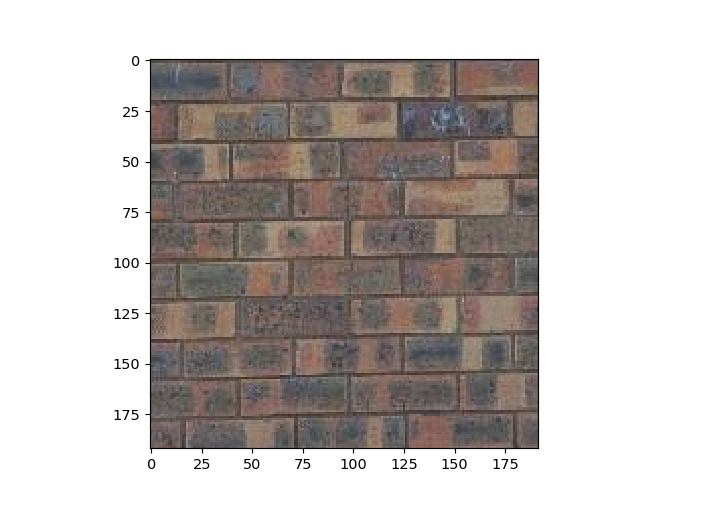

In [4]:
#https://images-na.ssl-images-amazon.com/images/I/81p-%2Bkp6%2BRL._AC_SL1500_.jpg bricks
#https://images.theconversation.com/files/133922/original/image-20160812-16339-v2g90o.png?ixlib=rb-1.1.0&q=45&auto=format&w=496&fit=clip cool patters
sample_img_dir = 'samples/bricks_small.jpg' # feel free to change
sample_img = None
if os.path.exists(sample_img_dir):
    sample_img = cv2.imread(sample_img_dir)
    sample_img = cv2.cvtColor(sample_img,cv2.COLOR_BGR2RGB)
    fig, axes = plt.subplots(1, 1)
    axes.imshow(sample_img)

<IPython.core.display.Javascript object>


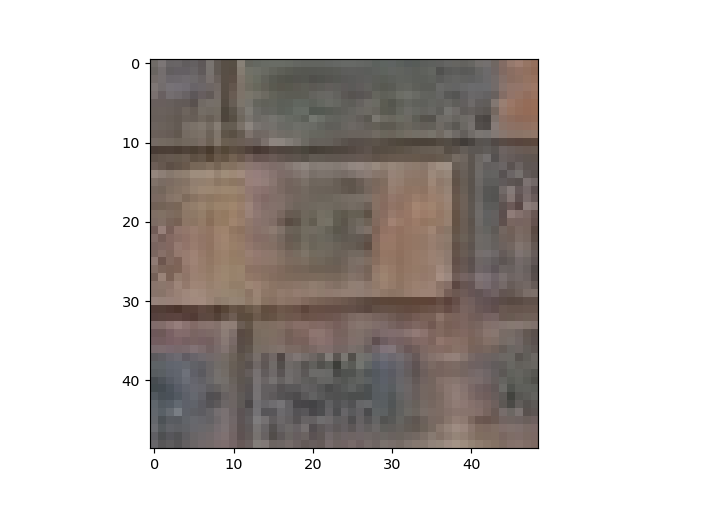

In [5]:
def sample_image(width,sample_img):
    row = sample_img.shape[0]
    column = sample_img.shape[1]
    random_row = randint(0,row - width)
    random_column = randint(0,column - width)
    new = sample_img[random_row:random_row + width,random_column:random_column + width,:]
    return new


fig, axes = plt.subplots(1, 1)
axes.imshow(sample_image(49,sample_img))


In [6]:
def quilt_random(sample, out_size, patch_size):
    """
    Randomly samples square patches of size patchsize from sample in order to create an output image of size outsize.

    :param sample: numpy.ndarray   The image you read from sample directory
    :param out_size: int            The width of the square output image
    :param patch_size: int          The width of the square sample patch
    :return: numpy.ndarray
    """
    size = out_size
    output = np.zeros(shape=(size,size,3))
    new = sample_image(patch_size,sample_img) 
    y = 0
    size_patch = new.shape[0]
    while y < size:
        x = 0
        while x < size:
            if x + size_patch > size and y + size_patch > size:
                new = sample_image(patch_size,sample_img)
                output[y:size,x:size] = new[0:size-y,0:size-x]
                break
            if x + size_patch > size:
                new = sample_image(patch_size,sample_img)
                output[y:size_patch+y,x:size] = new[:,0:size-x]
                break
            if y + size_patch > size:
                new = sample_image(patch_size,sample_img)
                output[y:size,x:size_patch+x] = new[0:size-y,:]
                x += size_patch
            else:
                new = sample_image(patch_size,sample_img)
                output[y:size_patch+y,x:size_patch+x] = new
                x += size_patch
        y += size_patch
    output = output.astype('uint8')
    return output

<IPython.core.display.Javascript object>


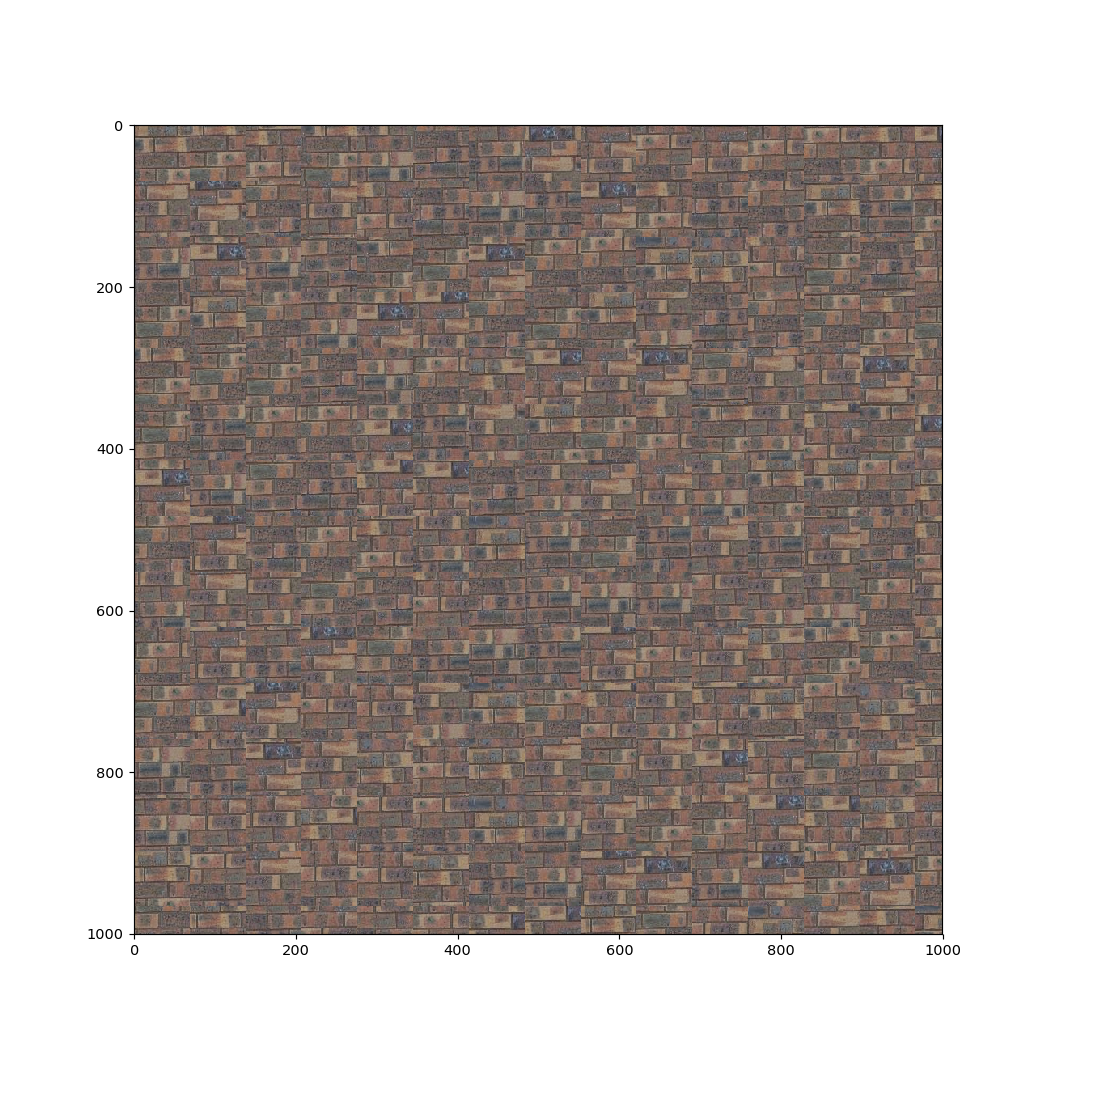

In [7]:
out_size = 1000 # feel free to change to debug
patch_size = 69 # feel free to change to debug
res = quilt_random(sample_img, out_size, patch_size)
fig, axes = plt.subplots(1, 1)
fig.set_size_inches(10, 10)
axes.imshow(res)
plt.savefig('bricks_small_random.png')

### Part II: Overlapping Patches (30 pts)

In [5]:
def ssd_patch_left(overlap,left_patch,patch_size):
    M = np.zeros(shape=(patch_size,patch_size,3))
    M[:,:overlap,:] = 1
    T = np.zeros(shape=(patch_size,patch_size,3))
    T[:,:overlap,:] = left_patch[:, patch_size-overlap:patch_size,:] #template overlap real values
    T/255.0
    I = sample_img/255.0
    ssd = ((M*T)**2).sum() - 2 * cv2.filter2D(I, ddepth=-1, kernel = M*T) + cv2.filter2D(I ** 2, ddepth=-1, kernel=M)
    return ssd

In [6]:
def ssd_patch_up(overlap,up_patch,patch_size):
    M = np.zeros(shape=(patch_size,patch_size,3))
    M[:overlap,:,:] = 1
    T = np.zeros(shape=(patch_size,patch_size,3))
    test = up_patch[patch_size-overlap:patch_size, :,:]
    test_2 = T[:overlap,:,:]
    T[:overlap,:,:] = up_patch[patch_size-overlap:patch_size, :,:] #template overlap real values
    T/255.0
    I = sample_img/255.0
    ssd = ((M*T)**2).sum() - 2 * cv2.filter2D(I, ddepth=-1, kernel = M*T) + cv2.filter2D(I ** 2, ddepth=-1, kernel=M)
    return ssd

In [7]:
def ssd_patch_both(overlap,up_patch,left_patch,patch_size):
    size_x = up_patch.shape[1]
    size_y = left_patch.shape[0] + overlap
    M = np.zeros(shape=(size_y,size_x,3))
    M[:overlap,:overlap,:] = 1
    T = np.zeros(shape=(size_y,size_x,3))
    T[:overlap,:,:] = up_patch #template overlap real values
    T[overlap:,:overlap,:] = left_patch
    T/255.0
    I = sample_img/255.0
    ssd = ((M*T)**2).sum() - 2 * cv2.filter2D(I, ddepth=-1, kernel = M*T) + cv2.filter2D(I ** 2, ddepth=-1, kernel=M)
    return ssd

In [190]:
def choose_sample(k,ssd,overlap,patch_size,input_image):
    input_image_size = input_image.shape[0]
    #print(input_image_size)
    row = []
    col = []
    z = []
    ssd_test = ssd[:,:,0]
    while len(row) < k:
        row_1, col_1 = np.where(ssd_test == np.amin(ssd_test))
        if (patch_size-1)/2<row_1[0] < input_image_size-((patch_size-1)/2) and (patch_size-1)/2<col_1[0] < input_image_size-((patch_size-1)/2):
            row.append(row_1[0])
            col.append(col_1[0])
        ssd_test[row_1,col_1] = 10000000000000
    #print (row, col, z)
    rand_int = randint(0,k-1)
    return input_image[row[rand_int]-int(((patch_size-1)/2)):(row[rand_int]-int((patch_size-1)/2))+patch_size,col[rand_int]-int((patch_size-1)/2):(col[rand_int]-int((patch_size-1)/2))+patch_size,:]

In [191]:
def quilt_simple(sample, out_size, patch_size, overlap, k):
    """
    Randomly samples square patches of size patchsize from sample in order to create an output image of size outsize.
    Feel free to add function parameters
    :param sample: numpy.ndarray
    :param out_size: int
    :param patch_size: int
    :param overlap: int
    :param k: int how many random samples to choose from smallest ssd values.
    :return: numpy.ndarray
    """
    output = np.zeros(shape=(out_size,out_size,3))
    y = 0
    t = 0
    print(t)
    while y < out_size:
        x = 0
        while x < out_size:
            if y == 0 and x == 0: #1
                random_sample = sample_image(patch_size,sample)
                output[:patch_size,:patch_size,:] = random_sample
                x += patch_size
                #print(y,x)
            elif y ==0 and x + patch_size <= out_size: #2
                left_patch = output[y:patch_size,x-patch_size:x,:]
                ssd = ssd_patch_left(overlap,left_patch,patch_size)
                out = choose_sample(k,ssd,overlap,patch_size,sample)
                output[y:patch_size,x:x+patch_size,:] = out
                x += patch_size
                #print(y,x)
            elif y ==0 and x + patch_size > out_size: #3
                left_patch = output[y:patch_size,x-patch_size:x,:]
                ssd = ssd_patch_left(overlap,left_patch,patch_size)
                out = choose_sample(k,ssd,overlap,patch_size,sample)
                output[y:patch_size,x:out_size,:] = out[:,:out_size-x,:]
                y += patch_size
                x = out_size + 1
                #print(y,x)
            elif y + patch_size <= out_size and x == 0:#4
                up_patch = output[y-patch_size:y,x:x+patch_size,:]
                ssd = ssd_patch_up(overlap,up_patch,patch_size)
                out = choose_sample(k,ssd,overlap,patch_size,sample)
                output[y:y+patch_size,x:x+patch_size,:] = out
                x += patch_size
                #print(y,x)
            elif y + patch_size <= out_size and x + patch_size <= out_size: #5
                up_patch = output[y-overlap:y,x-overlap:x+patch_size,:]
                left_patch = output[y:y+patch_size,x-overlap:x,:]
                ssd = ssd_patch_both(overlap,up_patch,left_patch,patch_size)
                out = choose_sample(k,ssd,overlap,patch_size,sample)
                output[y:y+patch_size,x:x+patch_size,:] = out
                x += patch_size
                #print(y,x)
            elif y + patch_size <= out_size and x + patch_size > out_size: #6
                up_patch = output[y-overlap:y,x-overlap:out_size,:]
                left_patch = output[y:y+patch_size,x-overlap:x,:]
                ssd = ssd_patch_both(overlap,up_patch,left_patch,patch_size)
                out = choose_sample(k,ssd,overlap,patch_size,sample)
                output[y:y+patch_size,x:out_size,:] = out[:,:out_size-x,:]
                x = out_size + 1
                y += patch_size
                #print(y,x)
            elif y + patch_size > out_size and x == 0: #7
                up_patch = output[y-patch_size:y,x:x+patch_size,:]
                ssd = ssd_patch_up(overlap,up_patch,patch_size)
                out = choose_sample(k,ssd,overlap,patch_size,sample)
                output[y:out_size,x:x+patch_size,:] = out[:out_size-y,:,:]
                x += patch_size
                #print(y,x)
            elif y + patch_size > out_size and x + patch_size <= out_size:
                up_patch = output[y-overlap:y,x-overlap:x+patch_size,:]
                left_patch = output[y:out_size,x-overlap:x,:]
                ssd = ssd_patch_both(overlap,up_patch,left_patch,patch_size)
                out = choose_sample(k,ssd,overlap,patch_size,sample)
                output[y:out_size,x:x+patch_size,:] = out[:out_size-y,:,:]
                x += patch_size  
            else:
                up_patch = output[y-overlap:y,x-overlap:out_size,:]
                left_patch = output[y:out_size,x-overlap:x,:]
                ssd = ssd_patch_both(overlap,up_patch,left_patch,patch_size)
                out = choose_sample(k,ssd,overlap,patch_size,sample)
                output[y:out_size,x:out_size,:] = out[:out_size-y,:out_size-x,:] 
                return output
                
                
                

0


<IPython.core.display.Javascript object>


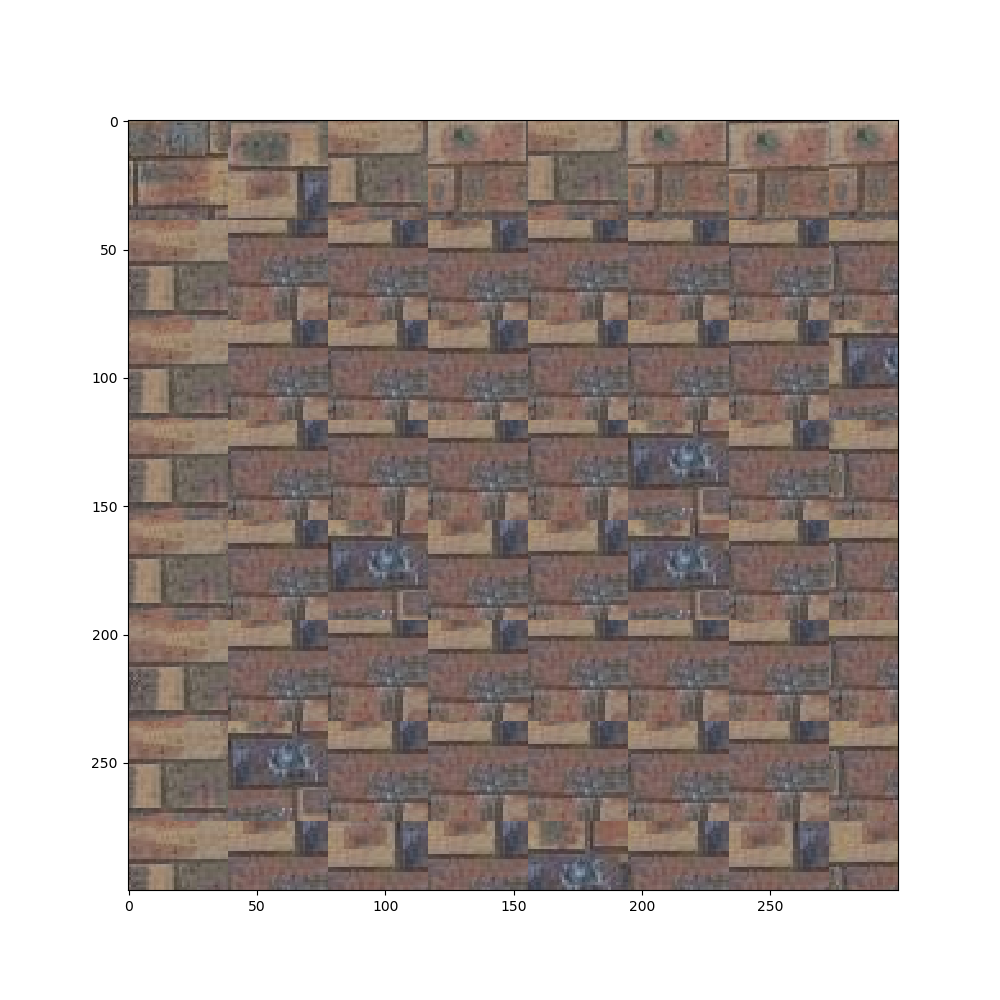

In [209]:
output = quilt_simple(sample_img, 300, 39, 10, 50)
output = output.astype('uint8')
fig, axes = plt.subplots(1, 1)
fig.set_size_inches(10, 10)
axes.imshow(output)
#plt.savefig('text_small_overlapping_patches.png')

### Part III: Seam Finding (20 pts)


In [193]:
def ssd_patch_left(overlap,left_patch,patch_size):
    M = np.zeros(shape=(patch_size,patch_size,3))
    M[:,:overlap,:] = 1
    T = np.zeros(shape=(patch_size,patch_size,3))
    T[:,:overlap,:] = left_patch[:, patch_size-overlap:patch_size,:] #template overlap real values
    T/255.0
    I = sample_img/255.0
    ssd = ((M*T)**2).sum() - 2 * cv2.filter2D(I, ddepth=-1, kernel = M*T) + cv2.filter2D(I ** 2, ddepth=-1, kernel=M)
    return ssd

In [194]:
def ssd_patch_up(overlap,up_patch,patch_size):
    M = np.zeros(shape=(patch_size,patch_size,3))
    M[:overlap,:,:] = 1
    T = np.zeros(shape=(patch_size,patch_size,3))
    test = up_patch[patch_size-overlap:patch_size, :,:]
    test_2 = T[:overlap,:,:]
    T[:overlap,:,:] = up_patch[patch_size-overlap:patch_size, :,:] #template overlap real values
    T/255.0
    I = sample_img/255.0
    ssd = ((M*T)**2).sum() - 2 * cv2.filter2D(I, ddepth=-1, kernel = M*T) + cv2.filter2D(I ** 2, ddepth=-1, kernel=M)
    return ssd

In [195]:
def ssd_patch_both(overlap,up_patch,left_patch,patch_size):
    size_x = up_patch.shape[1]
    size_y = left_patch.shape[0] + overlap
    M = np.zeros(shape=(size_y,size_x,3))
    M[:overlap,:overlap,:] = 1
    T = np.zeros(shape=(size_y,size_x,3))
    T[:overlap,:,:] = up_patch #template overlap real values
    T[overlap:,:overlap,:] = left_patch
    T/255.0
    I = sample_img/255.0
    ssd = ((M*T)**2).sum() - 2 * cv2.filter2D(I, ddepth=-1, kernel = M*T) + cv2.filter2D(I ** 2, ddepth=-1, kernel=M)
    return ssd

In [196]:
def overlap_patch_left(A,B,overlap,patch_size):
    #A is the left patch
    #B is the new patch
    row_size = A.shape[0]
    col_size = A.shape[1]
    s = (A[:,:,:]-B[:,:,:])**2
    s = s[:,:,0] + s[:,:,1] + s[:,:,2]
    s =  s.transpose()
    mask = cut(s)
    mask = mask.transpose()
    output_in = np.zeros(shape=(row_size,overlap,3))
    row = 0
    col = 0
    for x in mask:
        col = 0
        for y in x:
            if y == 0:
                output_in[row,col,:] = A[row,col,:]
            else:
                output_in[row,col,:] = B[row,col,:]
            #print(row,col)
            col += 1
        row += 1
    return output_in

In [197]:
def overlap_patch_up(A,B,overlap,patch_size):
    #A is the up patch
    #B is the new patch          
    row_size = A.shape[0]
    col_size = A.shape[1]
    s = (A[:,:,:]-B[:,:,:])**2
    s = s[:,:,0] + s[:,:,1] + s[:,:,2]
    mask = cut(s)
    output_in = np.zeros(shape=(overlap,col_size,3))
    row = 0
    col = 0
    for x in mask:
        col = 0
        for y in x:
            if y == 0:
                output_in[row,col,:] = A[row,col,:]
            else:
                output_in[row,col,:] = B[row,col,:]
            #print(row,col)
            col += 1
        row += 1
    return output_in

In [198]:
def choose_sample(k,ssd,overlap,patch_size,input_image):
    input_image_size = input_image.shape[0]
    #print(input_image_size)
    row = []
    col = []
    z = []
    ssd_test = ssd[:,:,0] + ssd[:,:,1] + ssd[:,:,2]
    while len(row) < k:
        row_1, col_1 = np.where(ssd_test == np.amin(ssd_test))
        if (patch_size-1)/2<row_1[0] < input_image_size-((patch_size-1)/2) and (patch_size-1)/2<col_1[0] < input_image_size-((patch_size-1)/2):
            row.append(row_1[0])
            col.append(col_1[0])
        ssd_test[row_1,col_1] = 10000000000000
    #print (row, col, z)
    rand_int = randint(0,k-1)
    return input_image[row[rand_int]-int(((patch_size-1)/2)):(row[rand_int]-int((patch_size-1)/2))+patch_size,col[rand_int]-int((patch_size-1)/2):(col[rand_int]-int((patch_size-1)/2))+patch_size,:]

In [203]:
def quilt_cut(sample, out_size, patch_size, overlap, k):
    """
    Samples square patches of size patchsize from sample using seam finding in order to create an output image of size outsize.
    Feel free to add function parameters
    :param sample: numpy.ndarray
    :param out_size: int
    :param patch_size: int
    :param overlap: int
    :param tol: float
    :return: numpy.ndarray
    """
    output = np.zeros(shape=(out_size,out_size,3))
    t = 0
    y = 0 #the current row value
    while y < out_size:
        x = 0 #current column value 
        while x < out_size:
            if y == 0 and x == 0: #1
                random_sample = sample_image(patch_size,sample)
                output[:patch_size,:patch_size,:] = random_sample
                x += patch_size
                print(y,x)
            elif y ==0 and x + patch_size - overlap <= out_size: #2
                left_patch = output[y:patch_size,x-patch_size:x,:]
                ssd = ssd_patch_left(overlap,left_patch,patch_size) 
                out = choose_sample(k,ssd,overlap,patch_size,sample)
                
                #left 
                A = left_patch[:,patch_size-overlap:,:] 
                B = out[:,:overlap,:]
                left = overlap_patch_left(A,B,overlap,patch_size)
                output[y:patch_size,x-overlap:x,:] = left
                
                #left over
                output[y:patch_size,x:x+patch_size-overlap,:] = out[:,overlap:,:]
                x = x + patch_size - overlap
                print(y,x)
            elif y ==0 and x + patch_size > out_size: #3
                left_patch = output[y:patch_size,x-patch_size:x,:]
                ssd = ssd_patch_left(overlap,left_patch,patch_size) 
                out = choose_sample(k,ssd,overlap,patch_size,sample)
                #left
                A = left_patch[:,patch_size-overlap:,:] 
                B = out[:,:overlap,:]
                left = overlap_patch_left(A,B,overlap,patch_size)
                output[y:patch_size,x-overlap:x,:] = left
                
                #left over
                output[y:patch_size,x:out_size,:] = out[:,overlap:out_size-x+overlap,:]
                x = out_size + 1
                y = y + patch_size
                print(y,x)
            elif y + patch_size <= out_size and x == 0:#4
                up_patch = output[y-patch_size:y,x:x+patch_size,:]
                ssd = ssd_patch_up(overlap,up_patch,patch_size)
                out = choose_sample(k,ssd,overlap,patch_size,sample)
                
                #up 
                A = up_patch[patch_size-overlap:,:,:]
                B = out[:overlap,:,:]
                up = overlap_patch_up(A,B,overlap,patch_size)
                output[y-overlap:y,x:patch_size,:] = up
                
                #left over
                output[y:y+patch_size-overlap,x:patch_size,:] = out[overlap:,:,:]
                x = x + patch_size
                print(y,x)
            elif y + patch_size <= out_size and x + patch_size <= out_size: #5
                up_patch = output[y-overlap:y,x-overlap:x+patch_size-overlap,:]
                left_patch = output[y:y+patch_size-overlap,x-overlap:x,:]
                
                ssd = ssd_patch_both(overlap,up_patch,left_patch,patch_size)
                out = choose_sample(k,ssd,overlap,patch_size,sample)
                
     
                #up
                A = up_patch
                B = out[:overlap,:,:]
                up = overlap_patch_up(A,B,overlap,patch_size)
                output[y-overlap:y,x-overlap:x+patch_size-overlap,:] = up
                
                #left
                A = left_patch
                B = out[overlap:,:overlap,:]

                
                left = overlap_patch_left(A,B,overlap,patch_size)
                output[y:y+patch_size-overlap,x-overlap:x,:] = left
                
                #leftover
                output[y:y+patch_size-overlap,x:x+patch_size-overlap,:] = out[overlap:,overlap:,:]
                x = x + patch_size - overlap
                print(y,x)
                
            elif y + patch_size <= out_size and x + patch_size > out_size: #6
                up_patch = output[y-overlap:y,x-overlap:out_size,:]
                left_patch = output[y:y+patch_size-overlap,x-overlap:x,:]
                
                ssd = ssd_patch_both(overlap,up_patch,left_patch,patch_size)
                out = choose_sample(k,ssd,overlap,patch_size,sample)
                
                #UP
                A = up_patch
                B = out[:overlap,:out_size-x+overlap]
                up = overlap_patch_up(A,B,overlap,patch_size)
                output[y-overlap:y,x-overlap:out_size,:] = up
                
                #left 
                A = left_patch
                B = out[overlap:,:overlap,:]

                
                left = overlap_patch_left(A,B,overlap,patch_size)
                output[y:y+patch_size-overlap,x-overlap:x,:] = left
                
                #leftover
                output[y:y+patch_size-overlap,x:out_size,:] = out[overlap:,overlap:out_size-x+overlap,:]
                x = out_size + 1
                y = y + patch_size - overlap
                
                print(y,x)
            elif y + patch_size > out_size and x == 0: #7
                up_patch = output[y-patch_size:y,x:x+patch_size,:]
                ssd = ssd_patch_up(overlap,up_patch,patch_size)
                out = choose_sample(k,ssd,overlap,patch_size,sample)
                
                #UP
                A = up_patch[patch_size-overlap:,:,:]
                B = out[:overlap,:,:]
                up = overlap_patch_up(A,B,overlap,patch_size)
                output[y-overlap:y,x:patch_size,:] = up
                
                #left over
                output[y:out_size,x:x+patch_size,:] = out[overlap:out_size-y+overlap,:,:]
                x = x + patch_size
                print(y,x)
            
            elif y + patch_size > out_size and x + patch_size <= out_size: #8
                up_patch = output[y-overlap:y,x-overlap:x+patch_size-overlap,:]
                left_patch = output[y:out_size,x-overlap:x,:]
                ssd = ssd_patch_both(overlap,up_patch,left_patch,patch_size)
                out = choose_sample(k,ssd,overlap,patch_size,sample)
                
                #up
                A = up_patch
                B = out[:overlap,:,:]
                up = overlap_patch_up(A,B,overlap,patch_size)
                output[y-overlap:y,x-overlap:x+patch_size-overlap,:] = up
                
                #left
                A = left_patch
                B = out[overlap:out_size - y + overlap,:overlap,:]
                left = overlap_patch_left(A,B,overlap,patch_size)
                output[y:y+patch_size-overlap,x-overlap:x,:] = left
                
                #leftover
                output[y:out_size,x:x+patch_size-overlap,:] = out[overlap:out_size-y+overlap,overlap:,:]
                x = x + patch_size - overlap
                print(y,x)
                 
            else:
                up_patch = output[y-overlap:y,x-overlap:out_size,:]
                left_patch = output[y:out_size,x-overlap:x,:]
                ssd = ssd_patch_both(overlap,up_patch,left_patch,patch_size)
                out = choose_sample(k,ssd,overlap,patch_size,sample)
                
                #up
                A = up_patch
                B = out[:overlap,:out_size-x+overlap]
                up = overlap_patch_up(A,B,overlap,patch_size)
                output[y-overlap:y,x-overlap:out_size,:] = up
                
                #left
                A = left_patch
                B = out[overlap:out_size - y + overlap,:overlap,:]
                left = overlap_patch_left(A,B,overlap,patch_size)
                output[y:y+patch_size-overlap,x-overlap:x,:] = left
                
                #leftover
                output[y:out_size,x:out_size,:] = out[overlap:out_size-y+overlap,overlap:out_size-x+overlap,:]
                return output

0 69
0 128
0 187
0 246
0 305
0 364
0 423
0 482
0 541
0 600
0 659
0 718
0 777
0 836
0 895
0 954
69 1001
69 69
69 128
69 187
69 246
69 305
69 364
69 423
69 482
69 541
69 600
69 659
69 718
69 777
69 836
69 895
69 954
128 1001
128 69
128 128
128 187
128 246
128 305
128 364
128 423
128 482
128 541
128 600
128 659
128 718
128 777
128 836
128 895
128 954
187 1001
187 69
187 128
187 187
187 246
187 305
187 364
187 423
187 482
187 541
187 600
187 659
187 718
187 777
187 836
187 895
187 954
246 1001
246 69
246 128
246 187
246 246
246 305
246 364
246 423
246 482
246 541
246 600
246 659
246 718
246 777
246 836
246 895
246 954
305 1001
305 69
305 128
305 187
305 246
305 305
305 364
305 423
305 482
305 541
305 600
305 659
305 718
305 777
305 836
305 895
305 954
364 1001
364 69
364 128
364 187
364 246
364 305
364 364
364 423
364 482
364 541
364 600
364 659
364 718
364 777
364 836
364 895
364 954
423 1001
423 69
423 128
423 187
423 246
423 305
423 364
423 423
423 482
423 541
423 600
423 659
423 718
42

<IPython.core.display.Javascript object>


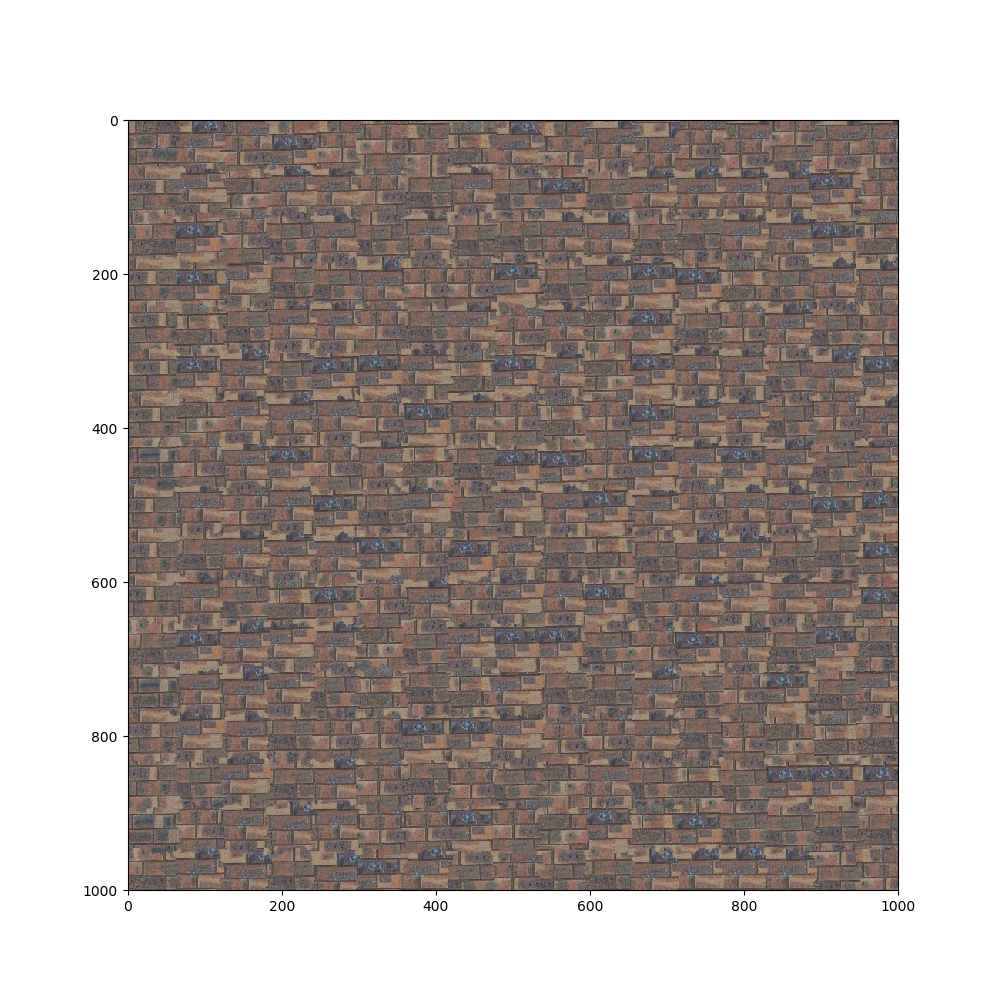

In [212]:
sample_img_dir = 'samples/bricks_small.jpg' # feel free to change
sample_img = None
if os.path.exists(sample_img_dir):
    sample_img = cv2.imread(sample_img_dir)
    sample_img = cv2.cvtColor(sample_img,cv2.COLOR_BGR2RGB)
output = quilt_cut(sample_img, 1000, 69, 10, 400)
output = output.astype('uint8')
fig, axes = plt.subplots(1, 1)
fig.set_size_inches(10, 10)
axes.imshow(output)
plt.savefig('bricks_small_seam_finding.png')

### part IV: Texture Transfer (30 pts)

### Bells & Whistles

(10 pts) Create and use your own version of cut.m. To get these points, you should create your own implementation without basing it directly on the provided function (you're on the honor code for this one). 

You can simply copy your customized_cut(bndcost) into the box below so that it is easier for us to grade

(15 pts) Implement the iterative texture transfer method described in the paper. Compare to the non-iterative method for two examples.

(up to 20 pts) Use a combination of texture transfer and blending to create a face-in-toast image like the one on top. To get full points, you must use some type of blending, such as feathering or Laplacian pyramid blending.

(up to 40 pts) Extend your method to fill holes of arbitrary shape for image completion. In this case, patches are drawn from other parts of the target image. For the full 40 pts, you should implement a smart priority function (e.g., similar to Criminisi et al.).